In [152]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import json
import sys

from utils.exact import exact_RK, pendulum
from utils.plotting import Plotting, get_optimal_figsize, legend_without_duplicate_labels, init_plot_style
from utils.postprocessing import PostProcessing
from utils.pathlib_helper import FileProcessing

init_plot_style(use_tex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
log_path = Path(Path.cwd(), '', 'logs',)  

search_path = Path('simi*', '**',
                #    'y0=[2.618*', '**',
                   't_* 2]_*', '**',
                   'lambda_*IC_1_*', '**'
                  )

print(str(search_path))

simi*\**\t_* 2]_*\**\lambda_*IC_1_*\**


In [109]:
FileProcessing_ = FileProcessing(log_path, search_path)
FileProcessing_.preprocessing_data_loading()
FileProcessing_.group_files(data_extension='*json')

c:\Users\sophi\Documents\GitHub\PINNs-code-cleaned\logs
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
\similar_y0\vanilla\y0=[2.461,2.461,0,0]\t_[0, 2]_norm_[-5, 5]\full_[0, 2]x0\6x30\lambda_IC_1_data_1 | x  1  | Idx:  0  | 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
\similar_y0\vanilla\y0=[2.478,2.478,0,0]\t_[0, 2]_norm_[-5, 5]\full_[0, 2]x0\6x30\lambda_IC_1_data_1 | x  1  | Idx:  1  | 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
\similar_y0\vanilla\y0=[2.496,2.496,0,0]\t_[0, 2]_norm_[-5, 5]\full_[0, 2]x0\6x30\lambda_IC_1_data_1 | x  1  | Idx:  2  | 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
\similar_y0\vanilla\y0=[2.513,2.513,0,0]\t_[0, 2]_norm_[-5, 5]\full_[0, 2]x0\6x30\lambda_IC_1_data_1 | x  1  | Idx:  3  | 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [110]:
data_2 = FileProcessing_.load_grouped_files(index=np.arange(16))   


****************************** Data Loaded! ******************************


****************************** Data Loaded! ******************************


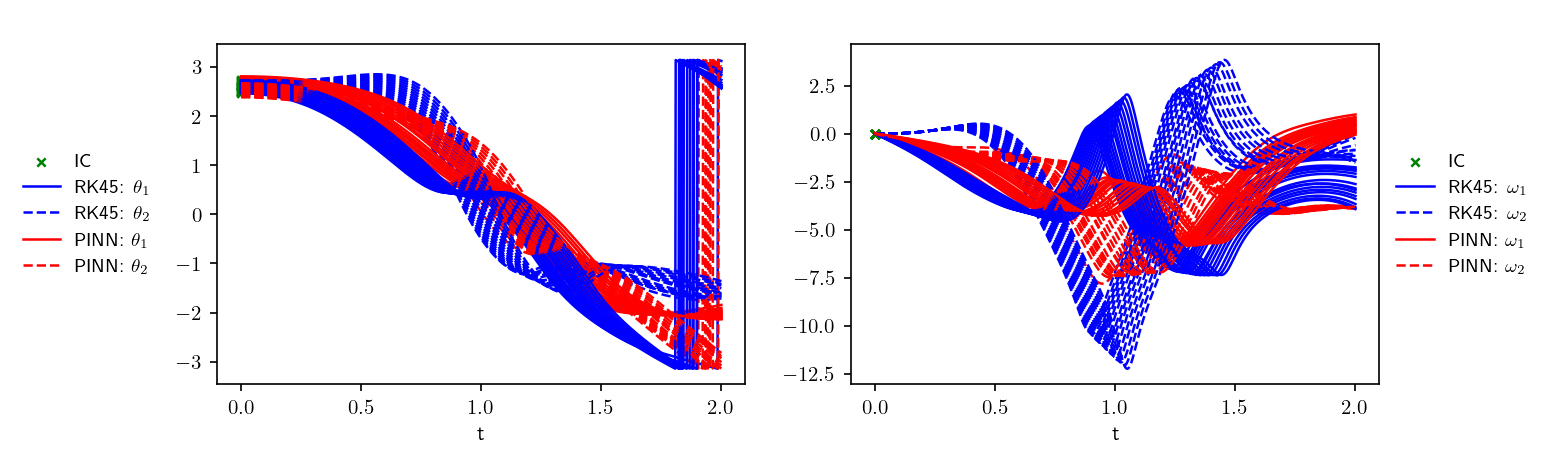

In [151]:
data = FileProcessing_.load_grouped_files(index=np.arange(16))   

fig, axes = plt.subplots(1,2, figsize=(10,3))
axes = axes.flatten()

for log in data: 
    Plot = Plotting(log, use_tex=True)
    Plot.plotting_yt_sol(axes[0:])
legend_without_duplicate_labels(axes[0], (-0.4, 0.5), idx = [-1, 0, 1, 2, 3], loc='center left');
legend_without_duplicate_labels(axes[1], (1, 0.5), idx = [-1, 0, 1, 2, 3], loc='center left');



In [68]:
from utils.solution_analysis import res_median_from_y, bandpower, get_theta_start_stop
from utils.exact import exact_RK
from matplotlib.ticker import FuncFormatter


In [177]:
theta_1_vec = np.arange(130,165,.5)
theta_2_vec = np.arange(130,165,.5)

theta_1_rad = theta_1_vec*np.pi/180
theta_2_rad = theta_1_vec*np.pi/180
th1_rad_mesh, th2_rad_mesh = np.meshgrid(theta_1_rad, theta_2_rad, indexing='ij')

y_grid = []
for row_th1, row_th2 in zip(th1_rad_mesh, th2_rad_mesh):
    y = [ [col_th1, col_th2, 0, 0]  for col_th1, col_th2 in zip(row_th1, row_th2)]
    y_grid.append(y)


In [190]:
xmax = 5
fmin = 0.5
N = 1000 
x = np.linspace(0,xmax,N)
d = []

for y0_row in y_grid:
    for y0 in y0_row:
        y_rk = exact_RK(x, y0)
        (res_x3_mean, res_x4_mean, res_x3_rhs_mean, res_x4_rhs_mean) = res_median_from_y(y_rk,x,xmax)

        T = xmax/len(y_rk[0,:])
        pow_RK45, yf_RK45_list, f_RK45 = bandpower(y_rk[0:2,:], 1/T, fmin=fmin)

        dict_temp = {'res_x3_mean':res_x3_mean,
                     'res_x4_mean':res_x4_mean,
                     'res_x3_rhs_mean':res_x3_rhs_mean,
                     'res_x4_rhs_mean':res_x4_rhs_mean,
                     'bandpower': pow_RK45/2,
                     'xmax': xmax,
                     'y0': y0
        }

        d.append(dict_temp)

df = pd.DataFrame(d)


bandpower_t_max_5_lambda_1


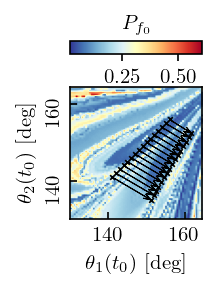

In [193]:
values = 'bandpower'    # bandpower res_rhs_mean

xmax = df['xmax'].to_numpy()[0]
if xmax == 2:
    data = data_2 
else:
    data = data_5

df['th_1'] = df['y0'].apply(lambda x: np.round( x[0]*180/np.pi, 2) )
df['th_2'] = df['y0'].apply(lambda x: np.round( x[1]*180/np.pi, 2) )
df['res_rhs_mean'] = df['res_x3_rhs_mean']+df['res_x4_rhs_mean']

table = pd.pivot_table(df,values=values,index=['th_2'], columns=["th_1"], aggfunc=lambda x:x)
pinn_theta_start, pinn_th1_final, pinn_th2_final, lambda_IC = get_theta_start_stop(data)

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
fig, axes = plt.subplots(1,1,figsize=get_optimal_figsize(scale=.3))
axes.tick_params(axis="y",direction="in")
axes.tick_params(axis="x",direction="in")

heatmap = axes.imshow(table, cmap ="RdYlBu_r", extent=[theta_1_vec.min(),theta_1_vec.max(),theta_2_vec.max(), theta_2_vec.min()])

cax = fig.add_axes([0.28, 1.07, .465,.07])
fmt = lambda x, pos: '{:.2f}'.format(x)
cbar_res = fig.colorbar(heatmap, format=FuncFormatter(fmt), cax=cax, pad=0.04, orientation="horizontal")
cbar_res.ax.set_title('$P_{f_0}$', rotation=0, fontsize=10)
cbar_res.ax.tick_params(axis="y",direction="in", rotation=90)

axes.invert_yaxis()
axes.tick_params(axis='y', labelrotation = 90)
axes.set_xlabel(r'$\theta_1{(t_0)}$ [deg]')
axes.set_ylabel(r'$\theta_2{(t_0)}$ [deg]')

axes.scatter(pinn_theta_start,pinn_theta_start,c='k',marker='x', s=5, lw=.8)
axes.scatter(pinn_th1_final,pinn_th2_final,c='k',marker='x', s=5, lw=.8)
for x_start, y_start, x_final, y_final in zip(pinn_theta_start, pinn_theta_start, pinn_th1_final-pinn_theta_start, pinn_th2_final-pinn_theta_start):
    axes.arrow(x_start, y_start, x_final, y_final,overhang=0.9, lw=0.5, length_includes_head=True, head_width=1.3, fc='k')

plot_name = '{}_t_max_{}_lambda_{}'.format(values, xmax, lambda_IC)
print(plot_name)
# pdf
plt.savefig(Path('', 'plots', plot_name+'.pdf'), bbox_inches='tight', transparent=True)
